In [9]:
import os
import numpy as np
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [10]:
# Paths
data_dir = '../data/'
pos_train_path = os.path.join(data_dir, "train_pos_full.txt")
neg_train_path = os.path.join(data_dir, "train_neg_full.txt")
test_path = os.path.join(data_dir, "test_data.txt")

In [11]:
# Load the data
with open(pos_train_path, 'r', encoding='utf-8') as f:
    pos_tweets = f.read().splitlines()

with open(neg_train_path, 'r', encoding='utf-8') as f:
    neg_tweets = f.read().splitlines()

with open(test_path, 'r', encoding='utf-8') as f:
    test_tweets = f.read().splitlines()

# Convert to DataFrames
pos_df = pd.DataFrame({'tweet': pos_tweets, 'label': 1})
neg_df = pd.DataFrame({'tweet': neg_tweets, 'label': 0})
test_df = pd.DataFrame({'tweet': test_tweets})

# Combine datasets
train_df = pd.concat([pos_df, neg_df], ignore_index=True)

### Preprocessing the tweets

In [12]:
def preprocess_tweets_df(df, text_column):
    """
    Preprocess tweets.
    - Removes URLs.
    - Removes the words 'user', '<user>', and user mentions.

    Args:
        the df: Input DataFrame containing the tweet data.
        text_column: Column name containing the tweets.

    Returns:
        new df: the df with the cleaned tweets.
    """
    def clean_tweet(tweet):
        # Remove URLs
        tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
        # Remove user mentions (@username)
        tweet = re.sub(r"@[A-Za-z0-9_]+", '', tweet)
        # Remove <user> placeholders
        tweet = re.sub(r"<user>", '', tweet)
        # Remove the word 'user'
        tweet = re.sub(r"\buser\b", '', tweet, flags=re.IGNORECASE)
        # Remove extra spaces
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        return tweet
    
    # Apply cleaning to the specified column
    df['tweet'] = df[text_column].apply(clean_tweet)
    return df


In [16]:
pd.set_option('display.max_colwidth', None)
train_df = preprocess_tweets_df(train_df, 'tweet')
train_df.head()

,tweet,label
0,"i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15",1
1,"because your logic is so dumb , i won't even crop out your name or your photo . tsk . <url>",1
2,""" just put casper in a box ! "" looved the battle ! #crakkbitch",1
3,thanks sir > > don't trip lil mama ... just keep doin ya thang !,1
4,visiting my brother tmr is the bestest birthday gift eveerrr ! ! !,1


### Ambiguous tweets analysis

In [17]:
text_column = 'tweet'
label_column = 'label' 

# Keywords for ambiguous detection
positive_smiley = ":)"
negative_smiley = ":("
ambiguous_keywords = ["not", "never", "no", "nothing", "bad", "sad", "ruined", "failed"]

# Function to detect ambiguity in tweets
def detect_ambiguity(tweet, label):
    tweet_lower = tweet.lower()
    contains_positive_smiley = positive_smiley in tweet_lower
    contains_negative_smiley = negative_smiley in tweet_lower
    contains_negative_words = any(word in tweet_lower for word in ambiguous_keywords)
    
    # Ambiguity: Positive smiley + negative words, or Negative smiley + positive context
    if (contains_positive_smiley and contains_negative_words) or (contains_negative_smiley and not contains_negative_words):
        return True
    return False

# Apply ambiguity detection
train_df['is_ambiguous'] = train_df.apply(lambda row: detect_ambiguity(row[text_column], row[label_column]), axis=1)

# Filter ambiguous examples
ambiguous_examples = train_df[train_df['is_ambiguous']]

# Display ambiguous examples
pd.set_option('display.max_colwidth', None)
print("Ambiguous Examples Detected:")
display(ambiguous_examples[[text_column, label_column]])


Ambiguous Examples Detected:


,tweet,label
876903,"could you say to me "" happy birthday "" ? even if i have had it a few of days ago ahahahaha tanto non mi caghi , stronzo :)",1
1156186,rt yooo rt allow rt behave ! rt i miss her :(,1
1260665,y dont follow me liam ? u can make me happy and make me feel better ( cuz im sick ) if u will follow me :( #liamfollow me,0
1557988,follow me greyson michael chance please :( have mercy on me :( t . t,0
1572245,me too . :( rt same goes here ... rt this period pain is killing me #lebihbaikmati,0
1652370,"oh doni toh , rt stop stop . dont speak anything about it . dn.brmsty :( rt frielarielela ( cont ) <url>",0
1657590,knpa ga aku ? please ksh 1tket aj untk aku . please bgt :(,0
1767776,"awe ... i mean im happy for you , but ill be alone ... im alreaddy missing you like crazy when you sleep ... :(",0
1778548,so hard : rt don't have to rt should i cry ? :(,0
1924261,ahh i can't see the live stream ... at the time you will be watching the concert i'll be having an exam tomorrow at college :(,0


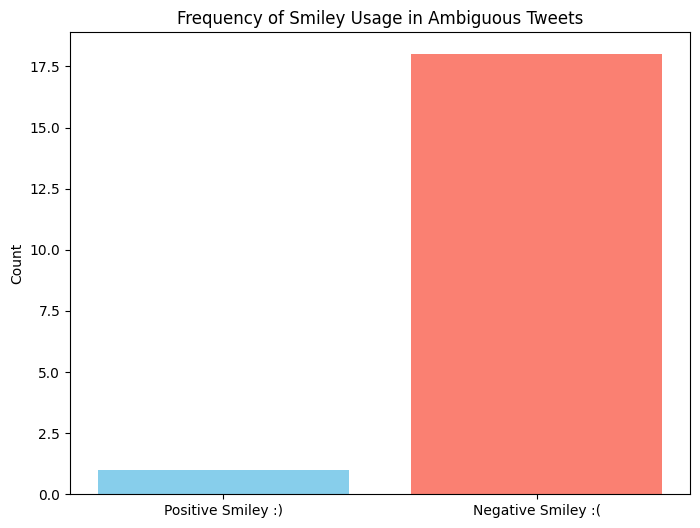

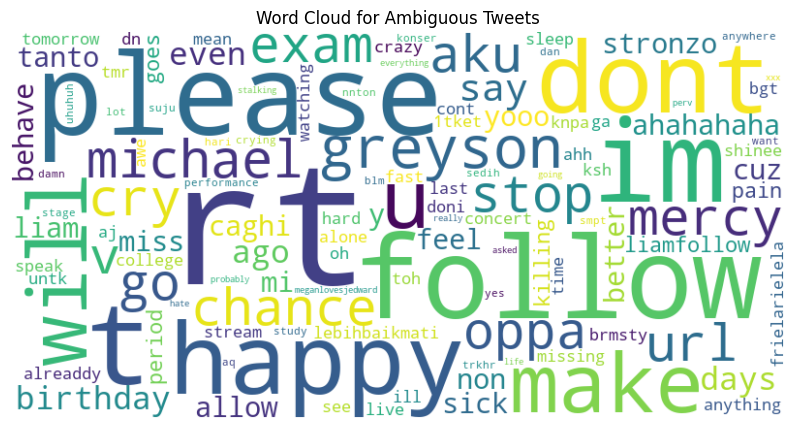

In [18]:
# Filter for ambiguous examples (assuming they are already tagged as 'is_ambiguous')
ambiguous_tweets = train_df[train_df['is_ambiguous']]

# 1. Analyze smiley presence in ambiguous examples
smiley_counts = {
    'Positive Smiley :)': ambiguous_tweets['tweet'].str.count(r'\:\)').sum(),
    'Negative Smiley :(': ambiguous_tweets['tweet'].str.count(r'\:\(').sum()
}

# Plot smiley counts
plt.figure(figsize=(8, 6))
plt.bar(smiley_counts.keys(), smiley_counts.values(), color=['skyblue', 'salmon'])
plt.title('Frequency of Smiley Usage in Ambiguous Tweets')
plt.ylabel('Count')
plt.show()

# 2. Generate Word Cloud for Ambiguous Tweets
text_combined = " ".join(ambiguous_tweets['tweet'].values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ambiguous Tweets')
plt.show()

In [20]:
def detect_misclassified_tweets(df, text_column, label_column):
    """
    Detect tweets that are misclassified based on smiley usage and labels.

    Args:
        df (pd.DataFrame): The DataFrame containing tweets and labels.
        text_column (str): The column name containing tweet text.
        label_column (str): The column name containing the tweet labels.

    Returns:
        pd.DataFrame: DataFrame of misclassified tweets.
    """
    positive_smiley = ":)"
    negative_smiley = ":("

    def is_misclassified(tweet, label):
        tweet_lower = tweet.lower()
        contains_positive_smiley = positive_smiley in tweet_lower
        contains_negative_smiley = negative_smiley in tweet_lower
        
        # Misclassification conditions:
        # Label 1 (positive) but contains a negative smiley
        # Label 0 (negative) but contains a positive smiley
        if (label == 1 and contains_negative_smiley) or (label == 0 and contains_positive_smiley):
            return True
        return False

    # Apply misclassification detection
    df['is_misclassified'] = df.apply(lambda row: is_misclassified(row[text_column], row[label_column]), axis=1)

    # Filter misclassified tweets
    misclassified_tweets = df[df['is_misclassified']]
    return misclassified_tweets

# Example usage:
# Assuming 'df_train' is your training DataFrame with columns 'tweet' and 'label'
misclassified = detect_misclassified_tweets(train_df, text_column='tweet', label_column='label')

# Display misclassified tweets
print("Misclassified Tweets:")
print(misclassified[['tweet', 'label']])

Misclassified Tweets:
                                                                                                tweet  \
223941   heres for all the filipino directioners ! ) i know we all want one direction concert here :(   
940549                                    your welcome " thankyou rt gwf " annovianti : gws for me :(   
1156186                                                 rt yooo rt allow rt behave ! rt i miss her :(   
1622328   so many things that i have to talk with u my best friend . gak sabar nunggu 6 bulan . (: :)   

         label  
223941       1  
940549       1  
1156186      1  
1622328      0  


In [23]:
def detect_tweets_with_smileys(df, text_column):
    """
    Detect tweets that contain smileys :) or :( in the text column.

    Args:
        df (pd.DataFrame): The DataFrame containing tweets.
        text_column (str): The column name containing tweet text.

    Returns:
        pd.DataFrame: A filtered DataFrame of tweets containing smileys.
    """
    smiley_pattern = r":\)|:\("  # Regex pattern to match :) or :(
    smiley_tweets = df[df[text_column].str.contains(smiley_pattern, regex=True)]
    return smiley_tweets

# Example usage:
# Assuming 'df_train' is your training DataFrame with a 'tweet' column
tweets_with_smileys = detect_tweets_with_smileys(train_df, text_column='tweet')

print(len(tweets_with_smileys))

# Print tweets containing smileys
print("Tweets with Smileys Detected:")
print(tweets_with_smileys[['tweet']])

31
Tweets with Smileys Detected:
                                                                                                                                  tweet
1357                      happy birthday :) keep handsome , longlife and everything . wish u all the best : > allah bless you . traktir
49897    follow me please , please , pleaseee , pleasee , just follow me i wanna someone from the cast follow me on twitter , please :)
155494                                                                                   thanks ! ) what a beautiful name you have . :)
223941                                     heres for all the filipino directioners ! ) i know we all want one direction concert here :(
592069            awn ... when i go to london i must meet you . so cute :) come to brazil ... my home is open to u ... you both love ya
876903       could you say to me " happy birthday " ? even if i have had it a few of days ago ahahahaha tanto non mi caghi , stronzo :)
940549         